<a href="https://colab.research.google.com/github/ZeroLeon/NLP_Project_with_FastAI/blob/master/DisasterTweetsDetection_Fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict which Tweets are about real disasters with Fastai

Kaggle Competition [link](https://www.kaggle.com/c/nlp-getting-started/overview)

## Preparation and download competition data

In [0]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from google.colab import drive
drive.mount('/content/gdrive',force_remount = True)
base_dir = '/content/gdrive/My Drive/fastai/'
path = Path(base_dir +'/data/')
#path.mkdir(parents=True,exist_ok=True) 
os.chdir(path) 

In [0]:
import plotly.express as px
import plotly.graph_objects as go
from fastai.text import *
from fastai.callbacks import * 

In [3]:
# !mkdir kaggle_disaster_tweets
%cd kaggle_disaster_tweets

/content/gdrive/My Drive/fastai/data/kaggle_disaster_tweets


In [57]:
!mkdir .kaggle

mkdir: cannot create directory ‘.kaggle’: File exists


In [0]:
!cp kaggle.json ~/.kaggle/kaggle.json

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [11]:
!kaggle competitions download -c nlp-getting-started

  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 26.6MB/s]
  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 6.13MB/s]
  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 31.2MB/s]


In [12]:
%ls

kaggle.json  sample_submission.csv  test.csv  train.csv


## Initial Data Exploration

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

In [5]:
train.shape,test.shape,sub.shape

((7613, 5), (3263, 4), (3263, 2))

In [6]:
train.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [7]:
train.isna().describe()

,id,keyword,location,text,target
count,7613,7613,7613,7613,7613
unique,1,2,2,1,1
top,False,False,False,False,False
freq,7613,7552,5080,7613,7613


In [8]:
train.location.dropna().sample(10)

3336               Manchester UK
4295                    Colorado
1276                      Canada
5909    Tractor land aka Bristol
6964        but i love kaylen ??
7505                      Mumbai
2308           Glasgow, Scotland
5874           MÌ©rida, YucatÌÁn
5675                   Ohio, USA
1352                 Los Angeles
Name: location, dtype: object

In [9]:
train.text.apply(len).value_counts().head(30)

136    401
139    275
138    256
140    218
137    210
135    191
134    128
133    114
132    113
130     91
91      88
126     84
100     79
120     79
131     78
129     78
101     78
122     77
114     77
87      77
128     76
79      74
117     73
85      73
92      72
96      72
88      71
124     71
95      70
123     70
Name: text, dtype: int64

In [26]:
train.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

Location has a lot of NaN values, training dataset is a little unbalanced

## Wordcloud to show the main content of these tweets

In [0]:
from wordcloud import WordCloud,STOPWORDS
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

In [0]:
tknzr = TweetTokenizer()

In [0]:
train['cutted'] = train.text.apply(lambda x:  ' '.join(tknzr.tokenize(x)))

In [12]:
train.cutted.iloc[5]

'#RockyFire Update = > California Hwy . 20 closed in both directions due to Lake County fire - #CAfire #wildfires'

In [0]:
total_text = " ".join(train.cutted.to_list())

In [0]:
train_real = train[train.target == 1].copy()
train_nreal =  train[train.target == 0].copy() #nreal == not real
real_text = " ".join(train_real.cutted.to_list())
nreal_text = " ".join(train_nreal.cutted.to_list())

In [0]:
stwlist=[line.strip() for line in open('eng_stopwords.txt','r',encoding='utf-8').readlines()]
# stopwords for English, can add custom words list later

def plotly_wordcloud(text):
    colors = ["#000000", "#111111", "#101010", "#121212", "#212121", "#222222"]
    cmap = LinearSegmentedColormap.from_list("mycmap", colors)
    wc = WordCloud(stopwords = set(STOPWORDS.union(set(stwlist))),
                   max_words = 300,
                   max_font_size = 120,
                   colormap=cmap,
                   random_state = 0,
                   )
    wc.generate(text)
    
    word_list=[]
    freq_list=[]
    fontsize_list=[]
    position_list=[]
    orientation_list=[]
    color_list=[]

    for (word, freq), fontsize, position, orientation, color in wc.layout_:
        word_list.append(word)
        freq_list.append(freq)
        fontsize_list.append(fontsize)
        position_list.append(position)
        orientation_list.append(orientation)
        color_list.append(color)
        
    # get the positions
    x=[]
    y=[]
    for i in position_list:
        x.append(i[0])
        y.append(i[1])
            
    # get the relative occurence frequencies
    new_freq_list = []
    for i in freq_list:
        new_freq_list.append((i*150+10))
    # new_freq_list
    
    trace = go.Scatter(x=x, 
                       y=y, 
                       textfont = dict(size=new_freq_list,
                                       color=color_list),
                       hoverinfo='text',
                       hovertext=['{0}{1}'.format(w, f) for w, f in zip(word_list, freq_list)],
                       mode='text',  
                       text=word_list
                      )
    
    layout = go.Layout({'xaxis': {'showgrid': False, 'showticklabels': False, 'zeroline': False},
                        'yaxis': {'showgrid': False, 'showticklabels': False, 'zeroline': False}})
    
    fig = go.Figure(data=[trace], layout=layout)
    fig.update_layout(plot_bgcolor='#D3DFE2')
    return fig

In [0]:
fig = plotly_wordcloud(total_text)


In [18]:
fig.show()

In [40]:
fig_real = plotly_wordcloud(real_text)
fig_real.show()

In [41]:
fig_nreal = plotly_wordcloud(real_text)
fig_nreal.show()

"CO" is from twitter's short url "t.co", we can do additional data cleaning to remove those meaningless words

## Basic Tweets Classification by Using Bert with Fastai 

In [0]:
%%capture
!pip install transformers

In [20]:
from transformers import BertTokenizer,BertForSequenceClassification

In [0]:
class easy_classification(BertForSequenceClassification):
  def forward(self, *args, **kwargs):
    return super().forward(*args, **kwargs)[0]

In [22]:
bert_model = easy_classification.from_pretrained('bert-base-uncased',num_labels=2)

In [23]:
bert_tok = BertTokenizer.from_pretrained(
   'bert-base-uncased'
)

In [24]:
bert_tok.tokenize(train.text.iloc[3])

['13',
 ',',
 '000',
 'people',
 'receive',
 '#',
 'wild',
 '##fires',
 'evacuation',
 'orders',
 'in',
 'california']

In [0]:
class FastAiBertTokenizer(BaseTokenizer):
    """Wrapper around BertTokenizer to be compatible with fast.ai"""
    def __init__(self, tokenizer: BertTokenizer, max_seq_len: int=128, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length"""
        return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

In [0]:
#
fastai_tokenizer = Tokenizer(
    tok_func=FastAiBertTokenizer(bert_tok, max_seq_len=128), 
    pre_rules=[], 
    post_rules=[]
)

In [27]:
list(bert_tok.vocab.items())[3100:3110]

[('okay', 3100),
 ('medal', 3101),
 ('kill', 3102),
 ('sun', 3103),
 ('cover', 3104),
 ('job', 3105),
 ('1985', 3106),
 ('introduced', 3107),
 ('chest', 3108),
 ('hell', 3109)]

In [0]:
fastai_bert_vocab = Vocab(list(bert_tok.vocab.keys()))

In [0]:
np.random.seed(0)
msk = np.random.rand(len(train)) < 0.7
train_data = train[msk]
valid_data = train[~msk]

# Using k-fold validation may improve the model generalizability

In [30]:
train_data.target.value_counts() #check the distribution of targets

0    3074
1    2288
Name: target, dtype: int64

In [31]:
valid_data.target.value_counts()

0    1268
1     983
Name: target, dtype: int64

In [32]:
text_cols = ['text']
label_cols = ['target']

databunch = TextClasDataBunch.from_df(".", train_data, valid_data, test,
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_bert_vocab,
                  include_bos=False,
                  include_eos=False,
                  text_cols= text_cols,
                  label_cols= label_cols,
                  bs=32,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )

In [33]:
databunch.show_batch(10)

text,target
[CLS] _ ? ? ? ? ? re ##t ##wee ##t ? ? ? ? ? ? ? ? ? ? ? ? follow all who rt ? ? ? ? ? ? ? ? ? ? ? ? follow ##back ? ? ? ? ? ? ? ? ? ? ? ? gain with ? ? ? ? ? ? ? ? ? ? ? ? follow ? @,0
[CLS] . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : rt dr ##ay ##esh ##a ##4 : # india ##ko ##mun ##tor ##ja ##wa ##b ##do indian army ki ##u _ http : / / t .,0
[CLS] 320 [ ir ] ice ##mo ##on [ after ##sho ##ck ] | http : / / t . co / y ##nx ##n ##v ##v ##k ##cd ##a | @ dj ##ice ##mo ##on | # dub ##ste ##p # trap ##music # d ##nb # ed ##m # dance # ice ##su _ http : / / t . co / we ##q ##pes ##en ##ku [SEP],0
[CLS] phones offers & gt ; & gt ; http : / / t . co / by ##t ##b ##z ##8 ##s ##5 ##ux # 03 ##4 8 - pin lightning connector 2 . 1a car charge ##r for apple 5 5 ##s 5 ##c 6 6 + ip ##u _ http : / / t . co / o ##3 ##w ##vs ##cl ##ic ##x [SEP],0
[CLS] # earthquake # sis ##mo m 1 . 9 - 15 ##km e of anchorage alaska : time ##20 ##15 - 08 - 06 00 : 11 : 16 utc ##20 ##15 - 08 - 05 16 : 11 : 16 - 08 : 00 . . . http : / / t . co / z ##0 ##ver ##1 ##h ##v ##m ##9 [SEP],1
[CLS] # nevada ' s u ##÷ ##ex ##ception ##al ##u ##ª # drought steady at ~ 11 % ; ~ 95 % of # n ##v in drought : http : / / t . co / ny ##o ##1 ##x ##ue ##bf ##a @ drought ##go ##v http : / / t . co / w ##0 ##a1 ##m ##jo ##rh ##y [SEP],1
[CLS] @ ca ##go ##v if 90 ##bl ##ks & amp ; 8 ##w ##ht ##s col ##lu ##ded 2 take w ##ht f @ usa ##go ##v au ##th hostage & amp ; 2 make her look b ##lk w / bio ##ter ##ror ##ism & amp ; use her l ##gl / org id ##is id still hers ? @ vp [SEP],1
[CLS] ( official vi ##d ) & gt ; # double ##cup ##s & gt ; & gt ; https : / / t . co / l ##fk ##mt ##za ##ek ##k & gt ; & gt ; @ tr ##ub ##gm ##e pro ##d @ this ##iz ##b ##wright & gt ; & gt ; # arm ##aged ##don . [SEP],0
[CLS] this is my jam : rise ##r by die ##rks bentley @ 106 ##1 ##the ##t ##wi ##ster ? # i ##heart ##rad ##io # now ##play ##ing http : / / t . co / z ##q ##os ##c ##q ##d ##64 ##h http : / / t . co / y ##l ##v ##v ##f ##13 ##9 ##bb [SEP],0
[CLS] the best thing at dq is the cotton candy blizzard ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? [SEP],0


In [0]:
loss_func = nn.CrossEntropyLoss()

In [0]:
learn = Learner( 
    databunch, 
    bert_model,
    loss_func=loss_func,
    metrics=[accuracy]
)

In [36]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.98E-04
Min loss divided by 10: 5.75E-05


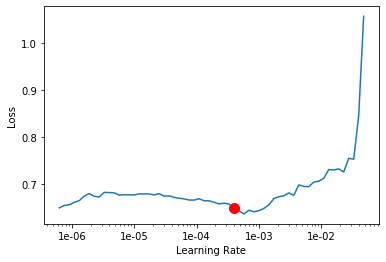

In [41]:
learn.recorder.plot(skip_end=8,suggestion=True)

In [42]:
learn.fit_one_cycle(3, max_lr=1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.505300,0.439330,0.809418,00:28
1,0.400683,0.412246,0.819636,00:27
2,0.334201,0.413484,0.819636,00:30


## Submit result to get a public score

In [46]:
sub.head(5)

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [0]:
def get_preds_as_nparray(ds_type) -> np.ndarray:

    preds = learn.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    ordered_preds = preds[reverse_sampler, :]
    pred_values = np.argmax(ordered_preds, axis=1)
    return ordered_preds, pred_values

In [48]:
result =get_preds_as_nparray(DatasetType.Test) # get ordered prediction from our fine-tuned model 

In [50]:
result[1]

array([1, 1, 1, 1, ..., 1, 1, 1, 1])

In [0]:
test['target'] = result[1].tolist()

In [53]:
test.target.value_counts()

0    1895
1    1368
Name: target, dtype: int64

In [0]:
submission_1st = test[['id','target']].copy()

In [0]:
submission_1st.to_csv('submission.csv',index=None)

In [64]:
!kaggle competitions submit -c nlp-getting-started -f submission.csv -m "1st submission"

100% 22.2k/22.2k [00:00<00:00, 44.2kB/s]
Successfully submitted to Real or Not? NLP with Disaster Tweets

Actually the whole dataset of this competition with label is available online, that's one of the reasons I picked up this competition as start session in new year of our fastai study group. 

Because we can now concentrate on the NLP skills and model learning process behind the competition instead of care too mush about the score ranking  :D



# Try it yourself!


*   Using more fastai features to improve your model performance, such as html cleaning in fastai.text
*   Using your customed bert family model and train it first on a vast twitter text data to get a higher outcome

